# Logs recovering

## Content

* [Task](#Task)
* [Dataset](#Dataset)
* [Model architecture](#Architecture)
* [Training](#Training)
* [Inference](#Inference)

## Task

Recover missed logs on the basis of known measurements

## Dataset


Logs from one place were used to train and estimate the model.

We choose the set of 12 logs measured for 90% of wells (321 wells) in the place: CFTC, CILD, GR, GZ1, GZ2, GZ3, GZ4, GZ7, LLD, NKTD, PROX и SP. This dataset can be represented as an array of 1d multichannel arrays of shape `[12, length]`, each array has a different length. The dataset was split into train and test in proportion 80:20. For each batch, we sample `n` uniformly from `range(3, 6)` and then split logs into `n` logs to recover and the remainder part as known logs. In the input crop, we pad channels that correspond to unknown logs by zeros and also create a binary mask with ones for unknown crops.

In [1]:
import os
import sys
sys.path.insert(0, os.path.join("..", "..", ".."))

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from well_logs import WellLogsDataset
from well_logs.batchflow import Pipeline, B, V
from well_logs.batchflow.models.torch import UNet
from well_logs.batchflow.models.tf.losses import softmax_cross_entropy, dice

In [2]:
WELL_NPZ_PATH = "/notebooks/data/geolog/npz/*.npz"
ds = WellLogsDataset(path=WELL_NPZ_PATH, no_ext=True, sort=True)
ds.split(0.8, shuffle=42)

## Architecture

To train the model we use U-Net with custom input block.

Model was trained on crops of size 256 with zeros for unknown channels. Weighted binary mask with trainable weights is summed with crop and the result is an input of U-Net. Loss for the model is element-wise MSE computed for missed channels.

In [3]:
class InitialBlock(nn.Module):
    def __init__(self, input_shapes):
        super().__init__()
        n_channels = input_shapes[0][1]
        self.b = nn.Parameter(torch.tensor([1.] * n_channels, requires_grad=True))
        self.output_shape = input_shapes[0]

    def forward(self, inputs):
        x, masks = inputs
        z = masks * self.b
        return x + z[..., np.newaxis]

class MyLoss(nn.Module):
    def forward(self, predictions, target):
        target, mask = target
        mse_element = mask[..., np.newaxis] * ((predictions - target) ** 2)
        return torch.sum(mse_element) / mask.sum() / predictions.shape[-1]    

class CustomUNet(UNet):
    def initial_block(self, inputs, **kwargs):
        return InitialBlock(inputs)

Configuration of the model:
* input shape - [256, 12]
* output shape - [256, 12]
* filters in decoder and encoder - [64, 128, 256, 512, 1024].

In [4]:
CROP_SIZE = 256

model_config = {
    'device': 'cuda:3',
    'initial_block/inputs': ('x', 'masks'),
    'inputs/x': {'shape': [12, CROP_SIZE]},
    'inputs/y': {'shape': [12, CROP_SIZE]},
    'inputs/masks': {'shape': (12, )},
    "head/num_classes": 12,
    'loss': MyLoss
}

## Training

In [5]:
N_EPOCH = 100
BATCH_SIZE = 32

In [6]:
def tile_masks(masks, logs):
    new_masks = []
    for log, mask in zip(logs, masks):
        mask = mask[None, ...]
        new_masks.append(np.tile(mask, (log.shape[0], 1)))
    return new_masks

def sampler(n_channels, min_size=3, max_size=6):
    size = np.random.randint(min_size, max_size+1)
    return np.random.choice(np.arange(n_channels), size=size, replace=False)

def concatenate_batch(batch, model, concat_mask=True):
    masks = tile_masks(batch.masks, batch.missed_logs)
    missed_logs = np.concatenate(batch.missed_logs).astype('float32')
    masks = np.concatenate(masks).astype('float32')
    
    feed_dict = {"inputs": (missed_logs, masks)}
    if concat_mask:
        feed_dict["targets"] = (np.concatenate(batch.logs).astype('float32'),
                                masks)
    return feed_dict

All the training process is described in pipeline

In [7]:
template_train_ppl = (Pipeline()
    .load(fmt="npz", components=["dept", "logs"])
    .init_variable('loss', init_on_each_run=list)
    .drop_nans()
    .add_components("missed_logs", B("array_of_nones"))
    .add_components("masks", B("array_of_nones"))
    .standardize(components="logs")
    .copy_components('logs', 'missed_logs')
    .fill_channels('missed_logs', sampler, 'masks')
    .random_crop(CROP_SIZE, n_crops=4, components=["logs", "missed_logs"])
    .init_model('dynamic', CustomUNet, 'model', model_config)
    .train_model('model', make_data=concatenate_batch, fetches='loss',
                 save_to=V('loss'), mode='a')
    .run(batch_size=BATCH_SIZE, n_epochs=N_EPOCH, shuffle=True, drop_last=True,
         lazy=True, bar=True)
)

In [8]:
train_ppl = (ds.train >> template_train_ppl)
train_ppl.run()

100%|██████████| 800/800 [07:23<00:00,  1.84it/s]


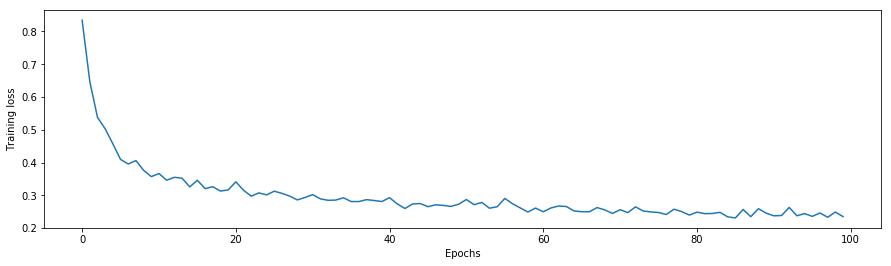

In [9]:
train_loss = [np.mean(l) for l in np.array_split(train_ppl.get_variable("loss"), N_EPOCH)]

fig = plt.figure(figsize=(15, 4))
plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.show()

Here we can see that learning process converged.

## Inference

To check the quality of the algorithm we plot some examples of recovered logs.

In [17]:
template_test_ppl = (Pipeline()
    .load(fmt="npz", components=["dept", "logs"])
    .init_variable('output', init_on_each_run=list)
    .init_variable('input', init_on_each_run=list)
    .drop_nans()
    .add_components("missed_logs", B("array_of_nones"))
    .add_components("masks", B("array_of_nones"))
    .standardize(components="logs")
    .copy_components('logs', 'missed_logs')
    .fill_channels('missed_logs', sampler, 'masks')
    .random_crop(CROP_SIZE, n_crops=4, components=["logs", "missed_logs"])
    .import_model('model', train_ppl)
    .predict_model('model', make_data=concatenate_batch, fetches='predictions',
                   save_to=V('output'), mode='w')
    .update_variable('input', [B('missed_logs'), B('logs'), B('masks'), B('meta')], mode='w')
    .run(batch_size=BATCH_SIZE, n_epochs=N_EPOCH, shuffle=True, drop_last=True, lazy=True)
)

In [18]:
test_ppl = (ds.test >> template_test_ppl)
test_ppl.next_batch()

In [19]:
logs, target, masks, meta =  test_ppl.get_variable('input')

masks = np.concatenate(tile_masks(masks, logs))
logs = np.concatenate(logs)
target = np.concatenate(target)
output = test_ppl.get_variable('output')

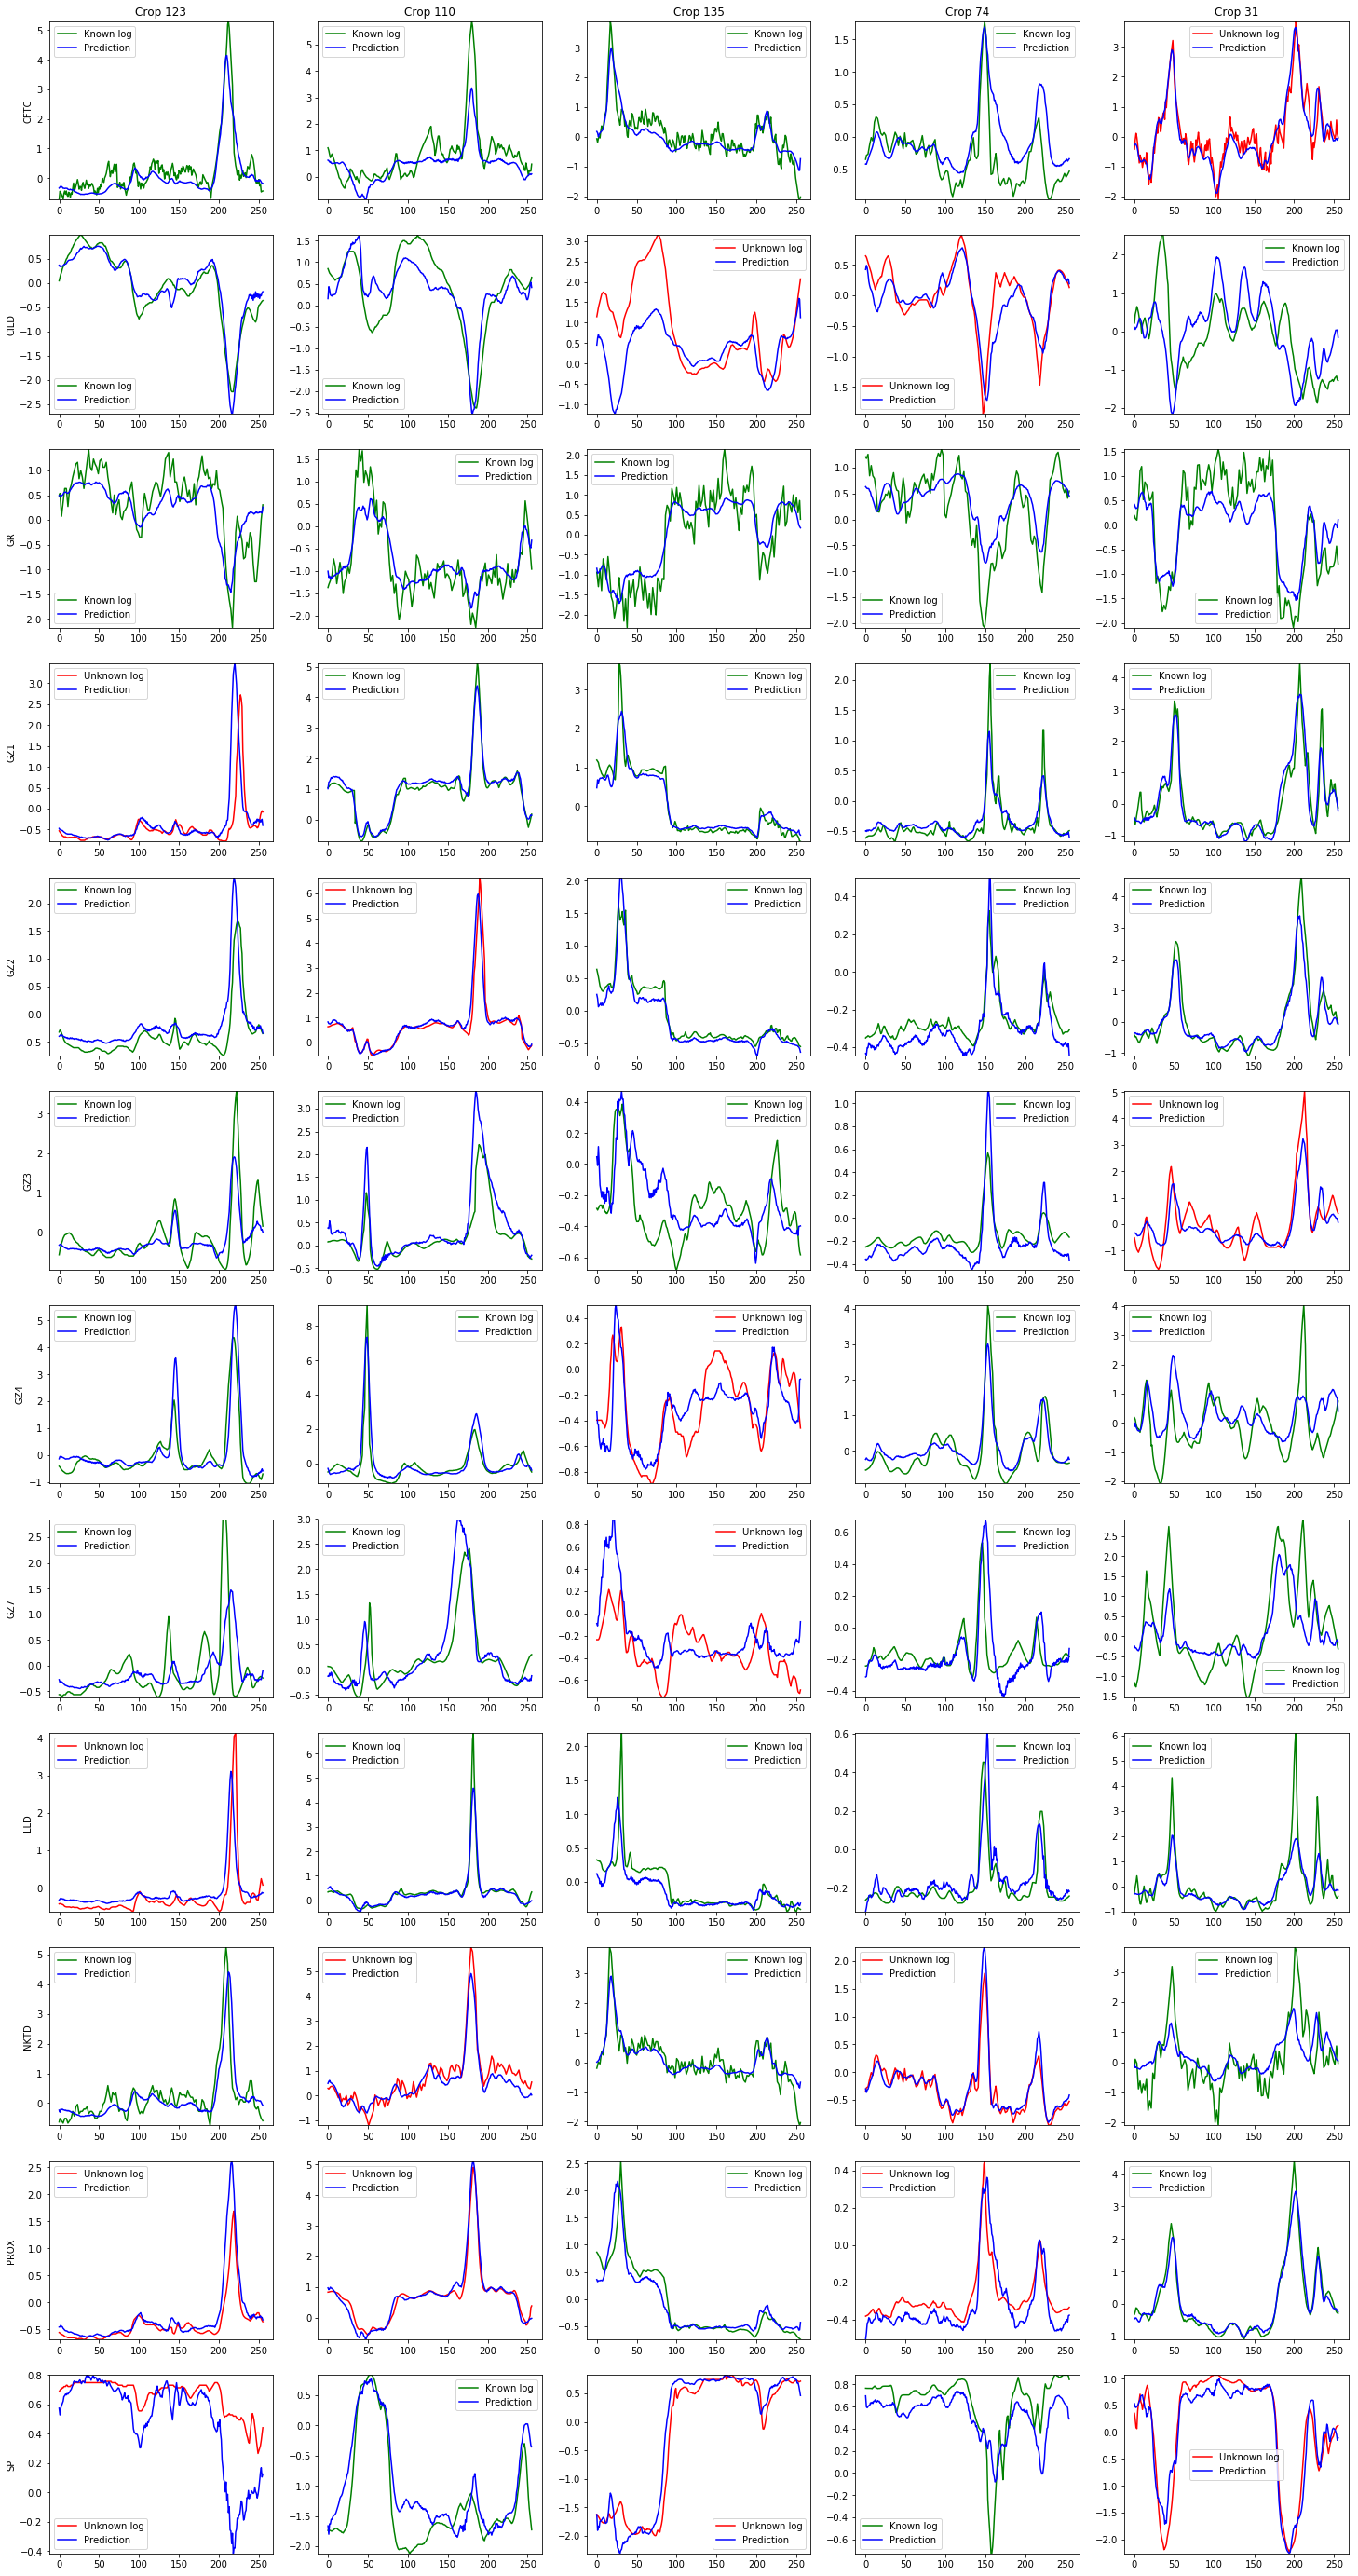

In [20]:
FULL_SET = np.array(['CFTC', 'CILD', 'GR', 'GZ1', 'GZ2', 'GZ3', 'GZ4', 'GZ7', 'LLD', 'NKTD', 'PROX', 'SP'])

n_crops = 5

plt.figure(figsize=(5 * n_crops, 50))

random_indices = np.random.choice(range(len(logs)), n_crops, replace=False)

for i in range(12):
    for j, crop in enumerate(random_indices):
        ymax = max(logs[crop, i].max(), target[crop, i].max(), output[crop, i].max())
        ymin = min(logs[crop, i].min(), target[crop, i].min(), output[crop, i].min())

        plt.subplot(12, n_crops, n_crops * i + j + 1)
        if j == 0:
            plt.ylabel(FULL_SET[i])
        if i == 0:
            plt.title('Crop {}'.format(crop))
        if masks[crop, i]:
            plt.plot(target[crop, i], color='r', label='Unknown log')
        else:
            plt.plot(logs[crop, i], color='g', label='Known log')

        plt.plot(output[crop, i], color='b', label='Prediction')
        plt.ylim((ymin, ymax))
        plt.legend()